In [1]:
!pip install datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.4 MB/s eta 0:00:00


In [30]:
import numpy  as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy



In [3]:
# read test and trian data and use Dataset library
data = DatasetDict()
df_train = pd.read_csv("/content/train_related.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_train = df_train.rename(columns={'General_comment': 'label'})
data['train'] = Dataset.from_pandas(df_train)

df_test = pd.read_csv("/content/test_related.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_test = df_test.rename(columns={'General_comment': 'label'})


df_test_unfreeze=df_test.copy()
df_test_unfreeze_11=df_test.copy()
df_test_freeze=df_test.copy()

data['test'] = Dataset.from_pandas(df_test)



In [7]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [8]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["Record_text"], padding=True, truncation=True, max_length = 50)
# Tokenize entire dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/5540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1225 [00:00<?, ? examples/s]

In [9]:
#Select mode of model
def freeze(model,mode):
    if mode=='unfreeze':
       for layer in model.get_layer('bert').encoder.layer:
            print(f"{layer.name}: {layer.trainable}")
    elif mode=='unfreeze_11':
       for layer in model.layers:
           layer.trainable = False
       model.get_layer('bert').encoder.layer[11].trainable=True  #11
       model.layers[-1].trainable = True   #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    else:
       for layer in model.layers:
           layer.trainable = False
       model.layers[-1].trainable = True  #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    return model

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [11]:
# Create tf datasets
BAtch_Size = 128
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns= ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=False,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
def compile(model):
  # Compile the model
  model.compile(
    optimizer=optimizers.Adam(learning_rate=9e-5),
    loss=model.hf_compute_loss,
    metrics=metrics.SparseCategoricalAccuracy()
)
  return model

In [13]:
# Training_function
def training(model,Epoch):
    EPOCHS = Epoch
    checkpoint_filepath = '/content/"training\cp.ckpt" '
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # Model weights are saved at the end of every epoch, if it's the best seen
    # so far.
    # Fit the model

    history = model.fit(tf_train_dataset,
              validation_data=tf_valid_dataset,
              epochs=EPOCHS)

In [14]:
#Mode
mode=['unfreeze','unfreeze_11','freeze']


## Mode: Un-freeze

In [15]:
num_labels=3
model_ = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:

model_=freeze(model_,mode[0])

layer_._0: True
layer_._1: True
layer_._2: True
layer_._3: True
layer_._4: True
layer_._5: True
layer_._6: True
layer_._7: True
layer_._8: True
layer_._9: True
layer_._10: True
layer_._11: True


In [17]:
#Compile
model_=compile(model_)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------





#### 3,more than 3 epoch --------->overfitt
#### Epoch = 3

In [18]:
training(model_,3)

Epoch 1/3
44/44 [==============================] - 108s 1s/step - loss: 0.9373 - sparse_categorical_accuracy: 0.5502 - val_loss: 0.8889 - val_sparse_categorical_accuracy: 0.6008
Epoch 2/3
44/44 [==============================] - 56s 1s/step - loss: 0.6587 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.9641 - val_sparse_categorical_accuracy: 0.5902
Epoch 3/3
44/44 [==============================] - 56s 1s/step - loss: 0.3512 - sparse_categorical_accuracy: 0.8709 - val_loss: 1.2169 - val_sparse_categorical_accuracy: 0.6065


---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

In [31]:
def pred_label(text):
    inputs = tokenizer(text, return_tensors="tf")
    logits =  model_(inputs).logits
    #logits =  model_unfreeze_11(inputs).logits
    # logits =  model_freeze(inputs).logits
      # print(logits)
    predict = int(tf.math.argmax(logits, axis=-1)[0])
      # print(predict)
    return predict
def Evaluate_models(df_test,model,label,mode):
    print(f":::::::::::::::Performance of ParsBERT'{mode}' on '{label}' Label:::::::::::::::::::")
    df_test["pred_label"]= df_test["Record_text"].apply(lambda x:pred_label(x))
    Real_label = df_test["label"].values
    predictions = df_test["pred_label"].values
    accuracy = accuracy_score(Real_label, predictions)
    print(classification_report(Real_label, predictions, labels=[0, 1,2], zero_division=0))
        #accuracy = accuracy_score(y_test, preds[i])
    print(f'''Accuracy: {round(accuracy_score(Real_label, predictions, normalize=True),6)}
    \nPrecision:{round(precision_score(Real_label, predictions, average='macro'),6)}
    \nRecall: {round(recall_score(Real_label, predictions, average='macro'),6)}
    \nF1 score: {round(f1_score(Real_label, predictions, average='macro'),6)}''')
    print('\n')
    print('\n')
    print('\n')
    print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    confusion_matrix = metrics.confusion_matrix(Real_label, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])
    cm_display.plot()
    plt.show()
    return df_test

:::::::::::::::Performance of ParsBERT'unfreeze' on 'General_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.69      0.36      0.48       269
           1       0.62      0.81      0.71       575
           2       0.53      0.46      0.50       381

    accuracy                           0.61      1225
   macro avg       0.61      0.55      0.56      1225
weighted avg       0.61      0.61      0.59      1225

Accuracy: 0.606531
    
Precision:0.614971
    
Recall: 0.547597
    
F1 score: 0.559646






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


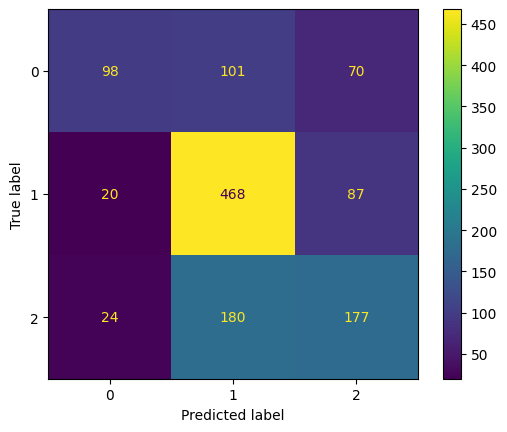

,Record_text,InRelationship,General_comment_binary,label,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,-1,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,1
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,1
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,-1,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,1
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,0,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,1
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,0,1,1,0.0,3,حرف ازدواج اصلا نزن,1,1
...,...,...,...,...,...,...,...,...,...
1220,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,1,1,2,1.0,2,کامنت,1,1
1221,خفه شو بابا برو زنتو جمع کن از دست فرانسوی ها ...,-1,1,1,0.0,3,کامنت,1,1
1222,خیانت ربطی به زیبایی پارتنر طرف نداره بلکه به ...,-1,1,1,0.0,3,کامنت,1,1
1223,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,1,1,2,1.0,2,کامنت,1,2


In [22]:
Evaluate_models(df_test_unfreeze,model_,'General_comment',mode[0])

In [ ]:
df_test_unfreeze_positive_general= df_test_unfreeze[(df_test_unfreeze['label'] == 0) & (df_test_unfreeze['pred_label'] == 0)]
df_test_unfreeze_negative_general = df_test_unfreeze[(df_test_unfreeze['label'] == 1) & (df_test_unfreeze['pred_label'] == 1)]
df_test_unfreeze_neutral_general = df_test_unfreeze[(df_test_unfreeze['label'] == 2) & (df_test_unfreeze['pred_label'] == 2)]

In [ ]:
df_test_unfreeze_positive_general.to_csv('/content/df_test_unfreeze_positive_general.csv')
df_test_unfreeze_negative_general.to_csv('/content/df_test_unfreeze_negative_general.csv')
df_test_unfreeze_neutral_general.to_csv('/content/df_test_unfreeze_neutral_general.csv')

----------------------------------------------------------------------------------------------------------------------------------------

## Mode: Freeze except layer 11


In [23]:
num_labels=3
model_unfreeze_11 = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model_unfreeze_11=freeze(model_unfreeze_11,mode[1])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: True


In [ ]:
#Compile
model_unfreeze_11=compile(model_unfreeze_11)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

#### Epoch =50

In [ ]:
training(model_unfreeze_11,50)

Epoch 1/50
34/34 [==============================] - 36s 628ms/step - loss: 1.0716 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.0433 - val_sparse_categorical_accuracy: 0.4777
Epoch 2/50
34/34 [==============================] - 16s 485ms/step - loss: 1.0441 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.0317 - val_sparse_categorical_accuracy: 0.4787
Epoch 3/50
34/34 [==============================] - 17s 492ms/step - loss: 1.0332 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.4836
Epoch 4/50
34/34 [==============================] - 17s 494ms/step - loss: 1.0271 - sparse_categorical_accuracy: 0.4791 - val_loss: 1.0161 - val_sparse_categorical_accuracy: 0.4906
Epoch 5/50
34/34 [==============================] - 17s 496ms/step - loss: 1.0247 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.0103 - val_sparse_categorical_accuracy: 0.4936
Epoch 6/50
34/34 [==============================] - 17s 499ms/step - loss: 1.0188 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'unfreeze_11' on 'General_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.51      0.19      0.28       223
           1       0.57      0.85      0.68       480
           2       0.48      0.33      0.39       306

    accuracy                           0.55      1009
   macro avg       0.52      0.46      0.45      1009
weighted avg       0.53      0.55      0.50      1009

Accuracy: 0.545094
    
Precision:0.519248
    
Recall: 0.456241
    
F1 score: 0.450243






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


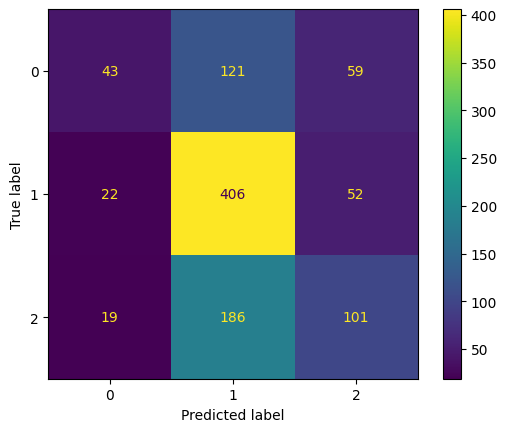

,Record_text,InRelationship,General_comment_binary,label,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,زید خاکی بریز شوهر دوبار خاک بریز,-1,1,1,0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,1
1,دوست پسر کاسب ساعت پیام میدین اوج بازاره دیوونه,1,1,1,1,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,1
2,عزیزی اندازه جان ادم نهار امد خونمون حسرت برطر...,1,1,0,1,0,خیلی زحمت کشید,1,0
3,نتونستم منظورمو برسونم خانمها نیاز بدونن مرد ح...,-1,1,0,0,3,مراقبت از هم,1,1
4,شوهر اسمش استاد حسین علیزاده کیهان کلهر,0,1,0,0,3,این دو ادم الگوست,1,2
...,...,...,...,...,...,...,...,...,...
1004,جهانی بوسه یادی معصومه خاکیار بوسه سینمای ایرا...,-1,1,1,0,3,بد,1,0
1005,کارمند حسو وقتیم کارمند حس زنیو شوهر معتاد خان...,-1,1,1,0,3,بد,1,1
1006,اقا روابطتون دهنتونو بازکنید راجب هرچی ناراحتت...,1,1,0,1,0,خوشایند,1,1
1007,توییتر لینکداین اینه دفه دوست دخترم دانشگاه ...,0,1,0,1,0,خوب,1,2


In [ ]:
Evaluate_models(df_test_unfreeze_11,model_unfreeze_11,'General_comment',mode[1])

---------------------------------------------------------------------------


## Mode: Freeze

In [26]:
num_labels=3
model_freeze = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model_freeze=freeze(model_freeze,mode[2])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: False


In [28]:
#Compile
model_freeze=compile(model_freeze)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

In [29]:
training(model_freeze,50)

Epoch 1/50
44/44 [==============================] - 43s 609ms/step - loss: 1.0620 - sparse_categorical_accuracy: 0.4502 - val_loss: 1.0416 - val_sparse_categorical_accuracy: 0.4710
Epoch 2/50
44/44 [==============================] - 23s 525ms/step - loss: 1.0366 - sparse_categorical_accuracy: 0.4773 - val_loss: 1.0270 - val_sparse_categorical_accuracy: 0.4792
Epoch 3/50
44/44 [==============================] - 23s 520ms/step - loss: 1.0237 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.0166 - val_sparse_categorical_accuracy: 0.4824
Epoch 4/50
44/44 [==============================] - 25s 567ms/step - loss: 1.0149 - sparse_categorical_accuracy: 0.4886 - val_loss: 1.0093 - val_sparse_categorical_accuracy: 0.4816
Epoch 5/50
44/44 [==============================] - 24s 543ms/step - loss: 1.0061 - sparse_categorical_accuracy: 0.4968 - val_loss: 1.0001 - val_sparse_categorical_accuracy: 0.5020
Epoch 6/50
44/44 [==============================] - 25s 561ms/step - loss: 0.9994 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'freeze' on 'General_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.58      0.35      0.44       269
           1       0.57      0.86      0.69       575
           2       0.56      0.30      0.39       381

    accuracy                           0.57      1225
   macro avg       0.57      0.50      0.50      1225
weighted avg       0.57      0.57      0.54      1225

Accuracy: 0.572245
    
Precision:0.569902
    
Recall: 0.502311
    
F1 score: 0.50488






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


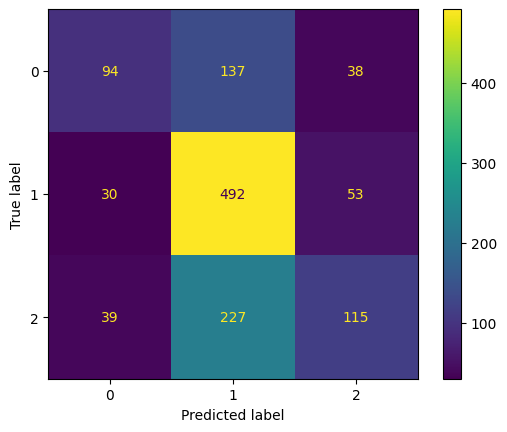

,Record_text,InRelationship,General_comment_binary,label,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,-1,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,1
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,1
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,-1,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,1
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,0,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,0
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,0,1,1,0.0,3,حرف ازدواج اصلا نزن,1,1
...,...,...,...,...,...,...,...,...,...
1220,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,1,1,2,1.0,2,کامنت,1,1
1221,خفه شو بابا برو زنتو جمع کن از دست فرانسوی ها ...,-1,1,1,0.0,3,کامنت,1,1
1222,خیانت ربطی به زیبایی پارتنر طرف نداره بلکه به ...,-1,1,1,0.0,3,کامنت,1,1
1223,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,1,1,2,1.0,2,کامنت,1,1


In [32]:
Evaluate_models(df_test_freeze,model_freeze,'General_comment',mode[2])